In [ ]:
# =========================
# Celda 0 — SETUP (seed=42)
# =========================
import os
# Determinismo 
os.environ["PYTHONHASHSEED"] = "42"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

import warnings, random, numpy as np, pandas as pd
warnings.filterwarnings("ignore")
# — Silenciar warnings de TF/Keras sin cambiar el resultado —
import os, warnings, logging
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # oculta INFO y WARNING del backend C++

try:
    import tensorflow as tf
    # Silencia el logger de TF 2.x
    tf.get_logger().setLevel(logging.ERROR)
    # Silencia avisos de absl usados por TF
    from absl import logging as absl_logging
    absl_logging.set_verbosity(absl_logging.ERROR)
    # Quita mensajes de deprecación internos
    from tensorflow.python.util import deprecation
    deprecation._PRINT_DEPRECATION_WARNINGS = False
except Exception:
    pass

# Filtro específico por si algún mensaje se cuela por el sistema de warnings de Python
warnings.filterwarnings("ignore", message=".*sparse_softmax_cross_entropy.*")


# Semillas base
RANDOM_STATE = 42
def _seed(s=RANDOM_STATE):
    random.seed(s); np.random.seed(s)
_seed()

# ---------- RUTAS / OBJETIVO ----------
FILES = {"corto": ("AMZN_modelo_corto_train.csv", "target_21d_logret_fwd")}
SPLITS = 5
GAP_MAP = {"corto": 21}

# ---------- Métricas ----------
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def _rmse(y, yhat): return float(np.sqrt(mean_squared_error(y, yhat)))
def _mae (y, yhat): return float(mean_absolute_error(y, yhat))
def _r2  (y, yhat):
    try:    return float(r2_score(y, yhat))
    except: return float("nan")
def _hit (y, yhat): return float(np.mean(np.sign(y) == np.sign(yhat)))

# ---------- Carga datos ----------
def load_xy(csv_path, target_col, date_col="Date"):
    df = pd.read_csv(csv_path)
    if date_col in df.columns:
        df = df.sort_values(date_col).reset_index(drop=True)
    num_cols = df.select_dtypes(include=["number"]).columns.tolist()
    assert target_col in df.columns, f"Falta columna objetivo: {target_col}"
    feats = [c for c in num_cols if c != target_col]
    X = df[feats]            
    y = df[target_col]       

    return df, X, y, feats

# ---------- Splits walk-forward con gap (purgado) ----------
def _feasible_folds(n, train_min, val_size, gap):
    numer = n - train_min - gap - val_size
    return 0 if numer < 0 else (numer // val_size) + 1

def make_wf_splits_capped(n, train_min, val_size, n_splits, gap=0):
    use = min(n_splits, _feasible_folds(n, train_min, val_size, gap))
    splits = []
    for i in range(use):
        train_end = train_min + i*val_size
        val_start = train_end + gap
        val_end   = val_start + val_size
        splits.append((np.arange(0, train_end), np.arange(val_start, val_end)))
    return splits

# ---------- Evaluador genérico por folds ----------
from sklearn.base import clone
def eval_model_wf(estimator, X, y, splits, random_state=RANDOM_STATE):
    np.random.seed(random_state)
    rows = []
    for k, (tr, va) in enumerate(splits, 1):
        Xtr, Xva = X.iloc[tr], X.iloc[va]
        ytr, yva = y.iloc[tr], y.iloc[va]


        # baseline: media de train (por fold)
        yb = np.full_like(yva, float(ytr.mean()), dtype=float)
        b_rmse, b_mae, b_r2, b_hit = _metrics(yva, yb)

        # modelo
        est = clone(estimator)
        est.fit(Xtr, ytr)
        yhat = est.predict(Xva)

        m_rmse, m_mae, m_r2, m_hit = _metrics(yva, yhat)

        rows.append({
            "fold": k,
            "rmse": m_rmse, "mae": m_mae, "r2": m_r2, "hit": m_hit,
            "base_rmse": b_rmse, "base_mae": b_mae, "base_r2": b_r2, "base_hit": b_hit
        })
    df = pd.DataFrame(rows)
    summary = df[["rmse","mae","r2","hit"]].mean().to_frame("mean")
    summary["std"] = df[["rmse","mae","r2","hit"]].std()
    return df, summary

def _metrics(y, yhat): 
    return _rmse(y,yhat), _mae(y,yhat), _r2(y,yhat), _hit(y,yhat)

# ---------- MODELOS (tuned) ----------
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Lineales
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
inner_cv = TimeSeriesSplit(n_splits=3)

LINEALES = {
    "OLS (ref)": Pipeline([
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        ("reg", LinearRegression())
    ]),
    "Lasso(tuned)": Pipeline([
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        ("reg", LassoCV(alphas=np.logspace(-4,0,25),
                        cv=inner_cv, max_iter=20000, random_state=RANDOM_STATE))
    ]),
    "ElasticNet(tuned)": Pipeline([
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        ("reg", ElasticNetCV(l1_ratio=[0.1,0.3,0.5,0.7,0.9],
                             alphas=np.logspace(-4,0,25),
                             cv=inner_cv, max_iter=20000, random_state=RANDOM_STATE))
    ]),
}

# Random Forest (determinista: n_jobs=1)
from sklearn.ensemble import RandomForestRegressor
RF_TUNED = RandomForestRegressor(
    n_estimators=500, max_depth=10, min_samples_leaf=5,
    max_features=0.7, bootstrap=True,
    random_state=RANDOM_STATE, n_jobs=1
)

# XGBoost (determinista: n_jobs=1, seed)
try:
    from xgboost import XGBRegressor
    XGB_TUNED = XGBRegressor(
        n_estimators=600, max_depth=5, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, min_child_weight=1.0,
        reg_alpha=0.0, reg_lambda=1.0, objective="reg:squarederror",
        tree_method="hist", eval_metric="rmse",
        random_state=RANDOM_STATE, n_jobs=1, verbosity=0
    )
    ENABLE_XGB = True
except Exception:
    ENABLE_XGB = False

# MLP (tuned) — determinista con solver lbfgs + seed
from sklearn.neural_network import MLPRegressor
def make_mlp_tuned(hidden=(64,), alpha=1e-5):
    return Pipeline([
        ("imputer", SimpleImputer()),
        ("scaler",  StandardScaler()),
        ("reg", MLPRegressor(
            hidden_layer_sizes=hidden, activation="tanh",
            solver="lbfgs", alpha=alpha,
            max_iter=20000, tol=1e-6,
            random_state=RANDOM_STATE,
        ))
    ])

# GRU (tuned) — con TF determinista
try:
    import tensorflow as tf
    from tensorflow import keras
    TF_OK = True
    tf.get_logger().setLevel("ERROR")
    tf.keras.utils.set_random_seed(RANDOM_STATE)
except Exception:
    TF_OK = False

def _fit_imputer_scaler(Xtr):
    imp = SimpleImputer().fit(Xtr)
    sc  = StandardScaler().fit(imp.transform(Xtr))
    class PIPE:
        def __init__(self, imp, sc): self.imp, self.sc = imp, sc
        def transform(self, X): return self.sc.transform(self.imp.transform(X))
    return PIPE(imp, sc)

def _build_seq(X, y, lookback):
    lookback = max(1, int(lookback))
    n = X.shape[0]
    if n <= lookback: return np.empty((0,lookback,X.shape[1])), np.empty((0,))
    Xs = np.array([X[i-lookback:i] for i in range(lookback, n)])
    ys = y[lookback:n]
    return Xs, ys

def make_gru(input_shape, units=64, l2=1e-3, dropout=0.1):
    reg = keras.regularizers.l2(l2)
    inp = keras.layers.Input(shape=input_shape)
    x = keras.layers.GRU(units,
                         kernel_regularizer=reg, recurrent_regularizer=reg,
                         dropout=dropout, return_sequences=False)(inp)
    out = keras.layers.Dense(1)(x)
    m = keras.Model(inp, out)
    m.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="mse")
    return m


In [ ]:
# =======================================
# Celda 1 — CORTO (≈21 días): evaluación
# =======================================
csv_path, target_col = FILES["corto"]
gap = GAP_MAP["corto"]

# Datos
df_raw, X, y, feats = load_xy(csv_path, target_col=target_col)
N = len(df_raw)

# Geometría
val_size  = max(50, N // 12)
train_min = max(200, val_size * 2)

# Splits WF con gap/purgado
splits = make_wf_splits_capped(N, train_min, val_size, SPLITS, gap=gap)

# --- baseline (media por fold) para skill común
base_rows = []
for (tr, va) in splits:
    ytr, yva = y.iloc[tr], y.iloc[va]
    yb = np.full(yva.shape[0], float(ytr.mean()), dtype=float)
    brmse, bmae, br2, bhit = _metrics(yva, yb)
    base_rows.append({"rmse":brmse,"mae":bmae,"r2":br2,"hit":bhit})
base_df = pd.DataFrame(base_rows)
RMSE_MEDIA = float(base_df["rmse"].mean())

rows = []
rows.append({
    "modelo":"Baseline(media)",
    "rmse": RMSE_MEDIA,
    "mae":  float(base_df["mae"].mean()),
    "r2":   float(base_df["r2"].mean()),
    "hit":  float(base_df["hit"].mean()),
    "skill_vs_media": 0.0
})

# --- catálogo de modelos (todos “tuned”, OLS referencia)
modelos = []
modelos.append(("OLS (ref)", LINEALES["OLS (ref)"]))
modelos.append(("Lasso(tuned)", LINEALES["Lasso(tuned)"]))
modelos.append(("ElasticNet(tuned)", LINEALES["ElasticNet(tuned)"]))
modelos.append(("RF(tuned)", RF_TUNED))
if ENABLE_XGB: modelos.append(("XGB(tuned)", XGB_TUNED))
modelos.append(("MLP(tuned)", make_mlp_tuned(hidden=(64,), alpha=1e-5)))

# --- evaluación
for nombre, est in modelos:
    _, summ = eval_model_wf(est, X, y, splits, random_state=RANDOM_STATE)
    rm = float(summ.loc["rmse","mean"])
    rows.append({
        "modelo": nombre,
        "rmse": rm,
        "mae":  float(summ.loc["mae","mean"]),
        "r2":   float(summ.loc["r2","mean"]),
        "hit":  float(summ.loc["hit","mean"]),
        # skill respecto a la MISMA baseline (constante por horizonte)
        "skill_vs_media": (1.0 - rm/RMSE_MEDIA) if RMSE_MEDIA>0 else np.nan
    })

# --- GRU (tuned)
if TF_OK:
    lb = max(1, gap)  # 21
    cfg = {"units":64, "l2":1e-3, "dropout":0.1}
    fold_rows = []

    for (tr, va) in splits:
        Xtr, Xva = X.iloc[tr], X.iloc[va]
        ytr, yva = y.iloc[tr], y.iloc[va]


        pre = _fit_imputer_scaler(Xtr)
        Xtr_s, Xva_s = pre.transform(Xtr), pre.transform(Xva)

        Xtr_seq, ytr_seq = _build_seq(Xtr_s, ytr, lb)
        Xva_seq, yva_seq = _build_seq(Xva_s, yva, lb)
        if Xtr_seq.shape[0]==0 or Xva_seq.shape[0]==0:
            continue

        tf.keras.utils.set_random_seed(RANDOM_STATE)
        model = make_gru(input_shape=(lb, X.shape[1]), **cfg)
        model.fit(Xtr_seq, ytr_seq, epochs=120, batch_size=64, verbose=0, shuffle=False)

        yhat = model.predict(Xva_seq, verbose=0).ravel()
        m_rmse = _rmse(yva_seq, yhat)
        m_mae  = _mae (yva_seq, yhat)
        m_r2   = _r2  (yva_seq, yhat)
        m_hit  = _hit (yva_seq, yhat)

        fold_rows.append({
            "rmse": m_rmse, "mae": m_mae, "r2": m_r2, "hit": m_hit
        })

    if fold_rows:
        df_gru = pd.DataFrame(fold_rows)
        rm_gru   = float(df_gru["rmse"].mean())
        mae_gru  = float(df_gru["mae"].mean())
        r2_gru   = float(df_gru["r2"].mean())
        hit_gru  = float(df_gru["hit"].mean())

        rows.append({
            "modelo": "GRU(tuned)",
            "rmse": rm_gru, "mae": mae_gru, "r2": r2_gru, "hit": hit_gru,
            # skill usando la MISMA baseline global del horizonte (constante)
            "skill_vs_media": (1.0 - rm_gru/RMSE_MEDIA) if RMSE_MEDIA>0 else np.nan
        })
    else:
        rows.append({"modelo":"GRU(tuned)","rmse":np.nan,"mae":np.nan,"r2":np.nan,"hit":np.nan,"skill_vs_media":np.nan})
else:
    rows.append({"modelo":"GRU(tuned)","rmse":np.nan,"mae":np.nan,"r2":np.nan,"hit":np.nan,"skill_vs_media":np.nan})

# --- TABLA FINAL ORDENADA POR RMSE
res_corto = pd.DataFrame(rows).sort_values("rmse").reset_index(drop=True)
res_corto


,modelo,rmse,mae,r2,hit,skill_vs_media
0,XGB(tuned),0.061101,0.043800,0.557190,0.804000,0.336812
1,RF(tuned),0.071283,0.051397,0.397247,0.810000,0.226296
2,MLP(tuned),0.079743,0.060820,0.248745,0.756000,0.134475
3,OLS (ref),0.083699,0.064631,0.156911,0.650000,0.091541
4,Lasso(tuned),0.084637,0.065944,0.142573,0.638000,0.081353
5,ElasticNet(tuned),0.084831,0.066075,0.137932,0.640000,0.079253
6,GRU(tuned),0.087415,0.067845,0.080491,0.627848,0.051204
7,Baseline(media),0.092132,0.070392,-0.007133,0.622000,0.000000


In [ ]:
# ======================================================
# Celda 2 — Guardar mejor (21 d) + baseline + predict()
# ======================================================
from joblib import dump, load

# Identifica el ganador por RMSE (excluye explícitamente el baseline)
tabla_sin_base = res_corto[res_corto["modelo"] != "Baseline(media)"].copy()
ganador = tabla_sin_base.iloc[0]["modelo"]
print("Mejor modelo (21 d):", ganador)

# Reinstancia el estimador ganador con la misma config
def _get_estimator_by_name(name):
    if name == "OLS (ref)":         return LINEALES["OLS (ref)"]
    if name == "Lasso(tuned)":      return LINEALES["Lasso(tuned)"]
    if name == "ElasticNet(tuned)": return LINEALES["ElasticNet(tuned)"]
    if name == "RF(tuned)":         return RF_TUNED
    if name == "XGB(tuned)":        return XGB_TUNED
    if name == "MLP(tuned)":        return make_mlp_tuned(hidden=(64,), alpha=1e-5)
    raise ValueError(f"Desconocido: {name}")

best_est = _get_estimator_by_name(ganador)
best_est.fit(X, y)

# imprime nombres de features si es XGB o scikit reciente
try:
    booster = best_est.get_booster()              # XGBRegressor
    print("XGB feature_names (primeras):", booster.feature_names[:5])
except Exception:
    print("No es XGB o no expone feature_names (ok).")

# Guardar modelo y baseline
MODEL_PATH = "model_21d.joblib"
dump(best_est, MODEL_PATH)

MEDIA_21D = float(y.mean())
with open("baseline_21d_media.txt", "w") as f:
    f.write(str(MEDIA_21D))

print(f"Modelo guardado en: {MODEL_PATH}")
print(f"Baseline media (21 d): {MEDIA_21D:.6f}")

# Wrappers para la app
def predict_21d(df_features):
    model = load(MODEL_PATH)
    X_inf = df_features[feats]  
    return model.predict(X_inf)

def predict_21d_media(n):
    with open("baseline_21d_media.txt") as f:
        mu = float(f.read().strip())
    return np.full(n, mu, dtype=float)


Mejor modelo (21 d): XGB(tuned)
XGB feature_names (primeras): ['close', 'volume', 'logret_1', 'roc_5', 'rsi_14']
Modelo guardado en: model_21d.joblib
Baseline media (21 d): 0.006591


Media log-return 21d: 0.006590747948447514
Media equivalente en % 21d: 0.6612514721202833


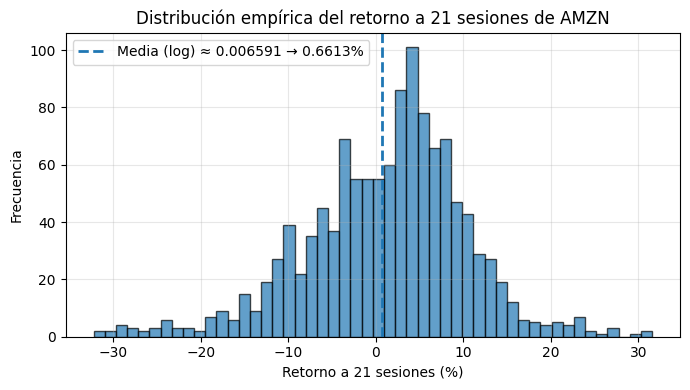

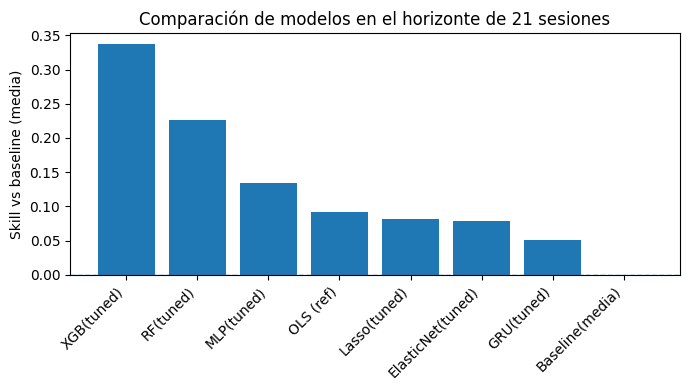

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

# ==========================================
# Figura — Histograma retorno 21 sesiones
# ==========================================

# y es target_21d_logret_fwd (log-retorno a 21 días)
rets_log_21d = y.values.astype(float)
rets_pct_21d = (np.exp(rets_log_21d) - 1.0) * 100.0

# Media en log-return y su equivalente en %
mean_log_21d = float(rets_log_21d.mean())
mean_pct_21d = (math.exp(mean_log_21d) - 1.0) * 100.0

print("Media log-return 21d:", mean_log_21d)
print("Media equivalente en % 21d:", mean_pct_21d)

plt.figure(figsize=(7, 4))
plt.hist(rets_pct_21d, bins=50, edgecolor="black", alpha=0.7)
plt.axvline(
    mean_pct_21d,
    linestyle="--",
    linewidth=2,
    label=f"Media (log) ≈ {mean_log_21d:.6f} → {mean_pct_21d:.4f}%"
)
plt.title("Distribución empírica del retorno a 21 sesiones de AMZN")
plt.xlabel("Retorno a 21 sesiones (%)")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ==========================================
# Figura Y — Skill vs media por modelo (21d)
# ==========================================

# res_corto ya viene de la celda anterior
tmp = res_corto.copy().sort_values("skill_vs_media", ascending=False)

plt.figure(figsize=(7, 4))
plt.bar(tmp["modelo"], tmp["skill_vs_media"])
plt.axhline(0.0, linestyle="--", linewidth=1)
plt.ylabel("Skill vs baseline (media)")
plt.title("Comparación de modelos en el horizonte de 21 sesiones")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [10]:
# Celda extra — Importancias globales XGB (21 d)
from joblib import load
import pandas as pd

# Cargo datos para recuperar la lista de features
csv_path, target_col = FILES["corto"]
df_raw, X, y, feats = load_xy(csv_path, target_col=target_col)

# Cargo el modelo final ya entrenado y guardado
model_21d = load("model_21d.joblib")

# Tabla de importancias ordenada
importances_21d = pd.DataFrame({
    "feature": feats,
    "importance": model_21d.feature_importances_
}).sort_values("importance", ascending=False)

print("Top 20 features XGB (21 d):")
print(importances_21d.head(20))




Top 20 features XGB (21 d):
               feature  importance
28        news_std_w21    0.126156
14         dist_sma400    0.102074
13         dist_sma200    0.072252
16        from_52w_low    0.064478
24       iv_minus_hv30    0.052941
27       news_mean_w21    0.051370
15       from_52w_high    0.046809
9     vol_ratio_21_252    0.045608
18        hv_yz_30_ext    0.045221
25  iv_ts_ratio_30_360    0.041354
0                close    0.038870
19       iv_atm_30_ext    0.036036
22  pc_ratio_oi_30_ext    0.032773
8        bb_width_20_2    0.028456
21      iv_skew_30_ext    0.027456
6           atr_14_pct    0.026778
11        sma_slope_20    0.024988
20       iv_atm_90_ext    0.024822
5            macd_hist    0.020665
12          dist_sma50    0.019017
